In [1]:
# import our libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
from collections import Counter
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

nlp = spacy.load('en_core_web_sm')

In [2]:
# Define Base URL
base_url = r"https://www.sec.gov/Archives/edgar/data"

# Set up the headers with a descriptive User-Agent
headers = {"User-Agent": "MyDataRetriever/1.0 (Contact: gseba@sandiego.edu)"}

# Get all companies data
tickers_json = requests.get("https://www.sec.gov/files/company_tickers.json", headers=headers)

In [3]:
# Review the response 
# print(tickers_json.json().keys())

In [4]:
# Format response as a dictionary and get first key/value
frist_entry = tickers_json.json()['0']

# Get CIK Numbers 
raw_cik = tickers_json.json()['0']['cik_str']

# Convert to a data frame
cik_df = pd.DataFrame.from_dict(tickers_json.json(), orient='index')

# Add leading zeros to CIK numbers for URL formatting
cik_df['cik_str'] = cik_df['cik_str'].astype(str).str.zfill(10)

# Display Data Frame
cik_df

,cik_str,ticker,title
0,0000320193,AAPL,Apple Inc.
1,0000789019,MSFT,MICROSOFT CORP
2,0001045810,NVDA,NVIDIA CORP
3,0001652044,GOOGL,Alphabet Inc.
4,0001018724,AMZN,AMAZON COM INC
...,...,...,...
10162,0001849820,KITTW,"Nauticus Robotics, Inc."
10163,0001276187,ET-PI,Energy Transfer LP
10164,0001571283,REXR-PC,"Rexford Industrial Realty, Inc."
10165,0001855756,LILMW,Lilium N.V.


In [5]:
# Function to find a single CIK number based on a company's ticker symbol
def get_cik_number_by_ticker(df, ticker_symbol):
    """
    Parameters:
    df (pd.DataFrame): DataFrame containing at least the 'ticker' and 'cik_str' columns.
    ticker_symbol (str): The ticker symbol of the company.

    Returns:
    str: The CIK number for the company if the ticker symbol is found, or a message if the ticker is not found.
    """
    result = df.loc[df['ticker'] == ticker_symbol, 'cik_str']  # Filter DataFrame for the ticker symbol
    
    if not result.empty:
        cik_number = result.iloc[0]  # Extract the first matching CIK number
        return cik_number  # Return the CIK number
    else:
        return f"Ticker symbol '{ticker_symbol}' not found in the dataset."  # Handle ticker not found


In [6]:
# Apply the function
ticker_to_search = 'NVDA'
cik_number = get_cik_number_by_ticker(cik_df, ticker_to_search)
print(f"The CIK number for {ticker_to_search} is: {cik_number}")

The CIK number for NVDA is: 0001045810


In [7]:
# # Function to find multiple CIK numbers based on a list company's ticker symbols
# def get_cik_numbers_by_tickers(df, ticker_symbols):
#     """
#     Parameters:
#     df (pd.DataFrame): DataFrame containing at least the 'ticker' and 'cik_str' columns.
#     ticker_symbols (list): List of ticker symbols of companies.

#     Returns:
#     dict: A dictionary mapping each ticker symbol to its corresponding CIK number or a not found message.
#     """
#     results = {}  # Dictionary to store the results

#     for ticker in ticker_symbols:
#         result = df.loc[df['ticker'] == ticker, 'cik_str']  # Filter DataFrame for the ticker symbol
        
#         if not result.empty:
#             cik_number = result.iloc[0]  # Extract the first matching CIK number
#             results[ticker] = cik_number  # Store the CIK number in the results dictionary
#         else:
#             results[ticker] = f"Ticker symbol '{ticker}' not found in the dataset."  # Handle ticker not found

#     return results  # Return the dictionary with CIK numbers and messages


In [8]:
# # Apply the function
# ticker_list = ['AAPL', 'MSFT', 'NVDA', 'WMT']
# cik_numbers = get_cik_numbers_by_tickers(cik_df, ticker_list)
# print(cik_numbers)

In [9]:
# Function to get company filing metadata based on the CIK number.
def get_filing_metadata(cik_number):
    """
    Parameters:
    cik_number (str): The CIK number of the company.

    Returns:
    dict or None: Parsed JSON data if successful, otherwise None.
    """
    url = f'https://data.sec.gov/submissions/CIK{cik_number}.json'
    response = requests.get(url, headers=headers)

    # Check the response status code before attempting to parse JSON
    if response.status_code == 200:
        try:
            data = response.json()
            print("Successfully retrieved JSON data.")
            return data
        except ValueError as e:
            print("Error parsing JSON:", e)
            print("Response Content (Preview):", response.text[:500])  # Display a preview of the response content
            return None
    else:
        print(f"Failed to retrieve data. Status Code: {response.status_code}")
        print("Response Content (Preview):", response.text[:500])  # Display a preview of the response content
        return None

# Get filing meta data
filing_metadata = get_filing_metadata(cik_number)

# If filing metadata is successfully retrieved, process the data
if filing_metadata:
    print(filing_metadata.keys())  # Display the top-level keys in the JSON
    filings = filing_metadata.get('filings', {}).get('recent', None)

    if filings:
        # Create a DataFrame from the recent filings
        forms_df = pd.DataFrame.from_dict(filings)
        print(forms_df.columns)  # Check columns in the DataFrame
    else:
        print("No recent filings found in the JSON data.")

Successfully retrieved JSON data.
dict_keys(['cik', 'entityType', 'sic', 'sicDescription', 'ownerOrg', 'insiderTransactionForOwnerExists', 'insiderTransactionForIssuerExists', 'name', 'tickers', 'exchanges', 'ein', 'description', 'website', 'investorWebsite', 'category', 'fiscalYearEnd', 'stateOfIncorporation', 'stateOfIncorporationDescription', 'addresses', 'phone', 'flags', 'formerNames', 'filings'])
Index(['accessionNumber', 'filingDate', 'reportDate', 'acceptanceDateTime',
       'act', 'form', 'fileNumber', 'filmNumber', 'items', 'core_type', 'size',
       'isXBRL', 'isInlineXBRL', 'primaryDocument', 'primaryDocDescription'],
      dtype='object')


In [10]:
# Explore resulting data frame
forms_df

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,core_type,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
0,0001045810-24-000296,2024-10-07,2024-10-03,2024-10-07T17:27:24.000Z,,4,,,,4,6816,0,0,xslF345X05/wk-form4_1728336437.xml,FORM 4
1,0001045810-24-000294,2024-10-01,2024-09-27,2024-10-01T16:19:18.000Z,,4,,,,4,6815,0,0,xslF345X05/wk-form4_1727813951.xml,FORM 4
2,0001045810-24-000292,2024-09-26,2024-09-24,2024-09-26T17:22:24.000Z,,4,,,,4,6818,0,0,xslF345X05/wk-form4_1727385738.xml,FORM 4
3,0001961863-24-000324,2024-09-24,,2024-09-24T17:58:48.000Z,33,144,000-23985,241320989,,144,247027,0,0,xsl144X01/primary_doc.xml,
4,0001045810-24-000290,2024-09-24,2024-09-20,2024-09-24T16:12:39.000Z,,4,,,,4,10129,0,0,xslF345X05/wk-form4_1727208751.xml,FORM 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0001045810-16-000296,2016-08-17,2016-08-15,2016-08-17T16:05:26.000Z,,4,,,,4,5087,0,0,xslF345X03/wf-form4_147146431382883.xml,FORM 4
997,0001045810-16-000294,2016-08-12,2016-08-10,2016-08-12T16:11:12.000Z,,4,,,,4,14123,0,0,xslF345X03/wf-form4_147103265663155.xml,FORM 4
998,0001045810-16-000292,2016-08-11,2016-08-11,2016-08-11T16:22:20.000Z,34,8-K,000-23985,161824893,"2.02,9.01",8-K,843096,0,0,form8-kq2fy17.htm,FORM 8-K
999,0001045810-16-000288,2016-07-15,2016-07-13,2016-07-15T16:43:32.000Z,,4,,,,4,14124,0,0,xslF345X03/wf-form4_146861539906570.xml,FORM 4


In [11]:
# Explore the unique values in the 'form' column
forms_df['form'].unique()

array(['4', '144', '10-Q', '8-K', '13F-HR', '3', 'SC 13G', 'SD', 'ARS',
       'DEFA14A', 'DEF 14A', '10-K', 'SC 13G/A', '4/A', 'UPLOAD',
       'CORRESP', '144/A', 'EFFECT', 'S-3/A', 'S-3', 'S-8', 'PRE 14A',
       '5', '424B5', 'FWP', '5/A', '8-K/A', 'S-3ASR', 'DFAN14A'],
      dtype=object)

In [12]:
# Filter the DataFrame for the '8-K' form
eight_k_filings = forms_df[forms_df['form'] == '8-K']

# Check if there are any '8-K' reports and display the accession numbers
if not eight_k_filings.empty:
    accession_numbers = eight_k_filings['accessionNumber'].tolist()
    print("Accession numbers for '8-K' reports:", accession_numbers)
else:
    print("No '8-K' reports found for the selected CIK number.")

Accession numbers for '8-K' reports: ['0001045810-24-000262', '0001045810-24-000206', '0001045810-24-000144', '0001045810-24-000113', '0001045810-24-000069', '0001045810-24-000028', '0001045810-23-000225', '0001045810-23-000221', '0001045810-23-000217', '0001045810-23-000171', '0001045810-23-000164', '0001045810-23-000146', '0001045810-23-000087', '0001045810-23-000039', '0001045810-23-000014', '0001045810-22-000163', '0001045810-22-000151', '0001045810-22-000146', '0001045810-22-000136', '0001045810-22-000133', '0001045810-22-000088', '0001045810-22-000073', '0001045810-22-000023', '0001045810-22-000008', '0001045810-22-000005', '0001045810-21-000160', '0001045810-21-000128', '0001045810-21-000117', '0001193125-21-192149', '0001045810-21-000075', '0001045810-21-000063', '0001045810-21-000056', '0001045810-21-000047', '0001045810-21-000034', '0001045810-21-000007', '0001045810-20-000187', '0001045810-20-000181', '0001193125-20-244601', '0001045810-20-000145', '0001045810-20-000127', '0

In [13]:
# Extract data from HTML table and format it as a string
def extract_table_data(table):
    rows = table.find_all('tr')
    table_text = [' | '.join(cell.get_text(strip=True) for cell in row.find_all(['td', 'th'])) for row in rows]
    return '\n'.join(table_text)

# Extract disclosure items and tables from HTML content
def extract_nvda_disclosures_xml(soup):
    items_content = {}
    current_item = None
    div_elements = soup.find_all(['div', 'table'])

    for element in div_elements:
        if element.name == 'div':
            text = element.get_text(strip=True)
            if "Item" in text:
                current_item = text
                items_content[current_item] = []
            elif current_item:
                items_content[current_item].append(text)
        elif element.name == 'table':  # Process table data
            table_data = extract_table_data(element)
            if current_item:
                items_content[current_item].append(table_data)

    for item, content_list in items_content.items():
        items_content[item] = ' '.join(content_list)

    return items_content

# Generate Form 8-K filing URLs using the SEC's index.json file
def generate_form_8k_urls(cik_number, accession_numbers):
    filing_urls = []
    base_url = f'https://www.sec.gov/Archives/edgar/data/{int(cik_number)}/'
    headers = {"User-Agent": "MyDataRetriever/1.0 (Contact: your_email@example.com)"}

    for accession_number in accession_numbers:
        formatted_accession = accession_number.replace('-', '')
        index_url = f"{base_url}{formatted_accession}/index.json"
        response = requests.get(index_url, headers=headers)
        time.sleep(1)  # Rate limiting

        if response.status_code == 200:
            try:
                data = response.json()
                for file_info in data.get('directory', {}).get('item', []):
                    if file_info['name'].lower().endswith('.htm') and '8-k' in file_info['name'].lower():
                        filing_urls.append(f"{base_url}{formatted_accession}/{file_info['name']}")
            except ValueError:
                print(f"Error parsing JSON at {index_url}")
        else:
            print(f"Failed to retrieve index for {accession_number}, status code {response.status_code}")

    return filing_urls

# Main code block to process filings
ticker_symbol = 'NVDA'
cik_number = get_cik_number_by_ticker(cik_df, ticker_symbol)
filing_metadata = get_filing_metadata(cik_number)

if filing_metadata:
    filings = filing_metadata.get('filings', {}).get('recent', None)

    if filings:
        forms_df = pd.DataFrame.from_dict(filings)
        eight_k_filings = forms_df[forms_df['form'] == '8-K']

        if not eight_k_filings.empty:
            accession_numbers = eight_k_filings['accessionNumber'].tolist()
            filing_urls = generate_form_8k_urls(cik_number, accession_numbers)

            headers = {"User-Agent": "MyDataRetriever/1.0 (Contact: your_email@example.com)"}
            for url in filing_urls:
                response = requests.get(url, headers=headers)
                time.sleep(1)

                if response.status_code == 200:
                    soup = BeautifulSoup(response.text, 'html.parser')
                    disclosure = extract_nvda_disclosures_xml(soup)
                    print(f"{ticker_symbol} Form 8-K Disclosures:")
                    for item, content in disclosure.items():
                        print(f"{item}: {content}\n")
                else:
                    print(f"Failed to fetch content for {url}")

            # Print separator for better readability
            print("\n" + "-" * 40 + "\n")
        else:
            print("No '8-K' reports found.")
    else:
        print("No recent filings found.")
else:
    print("Failed to retrieve filing metadata.")


Successfully retrieved JSON data.
NVDA Form 8-K Disclosures:
false000104581000010458102020-06-092020-06-09UNITED STATESSECURITIES AND EXCHANGE COMMISSIONWASHINGTON, DC 20549______________FORM8-KCURRENT REPORTPURSUANT TO SECTION 13 OR 15(d) OFTHE SECURITIES EXCHANGE ACT OF 1934Date of Report (Date of earliest event reported):June 9, 2020NVIDIA CORPORATION(Exact name of registrant as specified in its charter)Delaware0-2398594-3177549(State or other jurisdiction(Commission(IRS Employerof incorporation)File Number)Identification No.)2788 San Tomas Expressway,Santa Clara,CA95051(Address of principal executive offices)   (Zip Code)Registrant’s telephone number, including area code:(408)486-2000Not Applicable(Former name or former address, if changed since last report)Check the appropriate box below if the Form 8-K filing is intended to simultaneously satisfy the filing obligation of the registrant under any of the following provisions:☐Written communications pursuant to Rule 425 under the Se

In [14]:
# Store results for DataFrame creation
data_list = []

if filing_metadata:
    filings = filing_metadata.get('filings', {}).get('recent', None)

    if filings:
        forms_df = pd.DataFrame.from_dict(filings)
        eight_k_filings = forms_df[forms_df['form'] == '8-K']

        if not eight_k_filings.empty:
            accession_numbers = eight_k_filings['accessionNumber'].tolist()
            filing_urls = generate_form_8k_urls(cik_number, accession_numbers)

            headers = {"User-Agent": "MyDataRetriever/1.0 (Contact: your_email@example.com)"}
            for url in filing_urls:
                response = requests.get(url, headers=headers)
                time.sleep(1)

                if response.status_code == 200:
                    filing_content = response.text
                    soup = BeautifulSoup(filing_content, 'html.parser')
                    disclosure = extract_nvda_disclosures_xml(soup)

                    # Append formatted disclosure data to the list
                    for item, content in disclosure.items():
                        formatted_content = content.replace(' | ', '\n')  # Ensure table data is separated properly
                        data_list.append({
                            'CIK': cik_number,
                            'Accession Number': url.split('/')[-2],
                            'Item': item,
                            'Disclosure Text': formatted_content
                        })
                else:
                    print(f"Failed to fetch filing content for URL: {url}")
        else:
            print("No '8-K' reports found for the selected CIK number.")
    else:
        print("No recent filings found in the JSON data.")
else:
    print("Failed to retrieve filing metadata.")

# Create DataFrame from the results
filing_df = pd.DataFrame(data_list, columns=['CIK', 'Accession Number', 'Item', 'Disclosure Text'])

In [15]:
# Display the full text of the 'Item' column in your DataFrame
filing_df.head()

,CIK,Accession Number,Item,Disclosure Text
0,0001045810,000104581020000103,false000104581000010458102020-06-092020-06-09U...,false000104581000010458102020-06-092020-06-09 ...
1,0001045810,000104581020000103,Item 5.02. Departure of Directors or Certain O...,Amendment and Restatement of Amended and Resta...
2,0001045810,000104581020000103,Item 5.07. Submission of Matters to a Vote of ...,"At the 2020 Annual Meeting, the following pro..."
3,0001045810,000104581020000103,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits Exhibit NumberDescription...
4,0001045810,000104581020000052,false000104581000010458102020-04-272020-04-27U...,false000104581000010458102020-04-272020-04-27 ...


In [16]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

# Load the English stopwords from NLTK
stopwords_list = stopwords.words('english')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the stopwords, including custom stopwords specific to the domain
custom_stopwords = set(stopwords.words('english')).union({
    'herein', 'thereof', 'aforementioned', 'form', '8-k', 'nvidia', 'corporation', 'securities', 'exchange',
    'commission', 'share', 'meeting', 'vote', 'registrant', 'item', 'section', 'pursuant', 'act', 'inc', 'llc'
})

def clean_text(text):
    """Performs enhanced text cleaning to remove legal boilerplate and irrelevant characters."""
    # Remove common boilerplate phrases and legal text patterns
    text = re.sub(r'UNITED STATES SECURITIES AND EXCHANGE COMMISSION', '', text, flags=re.IGNORECASE)
    text = re.sub(r'FORM 8-K', '', text, flags=re.IGNORECASE)
    text = re.sub(r'CURRENT REPORT PURSUANT TO SECTION [0-9]+ OF THE SECURITIES EXCHANGE ACT OF 1934', '', text, flags=re.IGNORECASE)

    # Add spaces between numbers and words (ensures proper spacing in cases like 'for398number')
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)
    
    # Normalize dates and numbers
    text = re.sub(r'\b\d{4}-\d{2}-\d{2}\b', ' [DATE] ', text)
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remove unwanted characters and special symbols
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\\x\w{2}', '', text)
    text = re.sub(r'[☐]', '', text)
    
    # Remove punctuation, while keeping periods for potential sentence segmentation
    text = re.sub(r'[^\w\s\.\-]', '', text)
    
    # Remove single characters followed by a period (e.g., 'a.', 'm.', 'c.')
    text = re.sub(r'\b[a-zA-Z]\.\b', '', text)
    
    return text

def tokenize(text):
    """Tokenizes, lemmatizes, and removes stopwords, including filtering out single characters."""
    tokens = re.split(r'\s+', text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in custom_stopwords and len(token) > 1]
    return tokens

def prepare(text, pipeline):
    """Prepares text by applying a sequence of cleaning and transformation steps."""
    for transform in pipeline:
        text = transform(text)
    return text

# Define the text preprocessing pipeline
pipeline = [clean_text, tokenize]

# Function to preprocess the 'Disclosure Text' column in the existing DataFrame
def preprocess_disclosure_text(df):
    """Applies text preprocessing to the 'Disclosure Text' column of the existing DataFrame."""
    df['Processed Disclosure Text'] = df['Disclosure Text'].apply(
        lambda x: ' '.join(prepare(x, pipeline)) if isinstance(x, str) else ''
    )
    return df


In [17]:
# Apply preprocessing to the 'Disclosure Text' column in your existing DataFrame
filing_df = preprocess_disclosure_text(filing_df)

# Display the DataFrame with the processed disclosure text
filing_df.head()


,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
0,0001045810,000104581020000103,false000104581000010458102020-06-092020-06-09U...,false000104581000010458102020-06-092020-06-09 ...,false ---- washington dc ______________ -k cur...
1,0001045810,000104581020000103,Item 5.02. Departure of Directors or Certain O...,Amendment and Restatement of Amended and Resta...,amendment restatement amended restated equity ...
2,0001045810,000104581020000103,Item 5.07. Submission of Matters to a Vote of ...,"At the 2020 Annual Meeting, the following pro...",annual following proposal adopted margin indic...
3,0001045810,000104581020000103,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits Exhibit NumberDescription...,exhibit exhibit numberdescription amended rest...
4,0001045810,000104581020000052,false000104581000010458102020-04-272020-04-27U...,false000104581000010458102020-04-272020-04-27 ...,false ---- washington dc ______________ -k cur...


In [18]:
# Convert 'reportDate' to datetime
filing_df['reportDate'] = pd.to_datetime(forms_df['reportDate'], errors='coerce')

# Reorder columns with 'reportDate' first
columns_order = ['reportDate', 'CIK', 'Accession Number', 'Item', 'Disclosure Text', 'Processed Disclosure Text']
filing_df = filing_df[columns_order]

# Merge 'reportDate' into 'filing_df' using 'Accession Number' with suffixes
filing_df = filing_df.merge(forms_df[['accessionNumber', 'reportDate']],
                            left_on='Accession Number',
                            right_on='accessionNumber',
                            how='left',
                            suffixes=('_filing', '_form'))

# Drop redundant 'accessionNumber' and 'reportDate_form' columns
filing_df.drop(columns=['accessionNumber', 'reportDate_form'], inplace=True)

# Rename 'reportDate_filing' to 'reportDate'
filing_df.rename(columns={'reportDate_filing': 'reportDate'}, inplace=True)

# Display updated DataFrame
filing_df.head(50)

,reportDate,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
0,2024-10-03,0001045810,000104581020000103,false000104581000010458102020-06-092020-06-09U...,false000104581000010458102020-06-092020-06-09 ...,false ---- washington dc ______________ -k cur...
1,2024-09-27,0001045810,000104581020000103,Item 5.02. Departure of Directors or Certain O...,Amendment and Restatement of Amended and Resta...,amendment restatement amended restated equity ...
2,2024-09-24,0001045810,000104581020000103,Item 5.07. Submission of Matters to a Vote of ...,"At the 2020 Annual Meeting, the following pro...",annual following proposal adopted margin indic...
3,NaT,0001045810,000104581020000103,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits Exhibit NumberDescription...,exhibit exhibit numberdescription amended rest...
4,2024-09-20,0001045810,000104581020000052,false000104581000010458102020-04-272020-04-27U...,false000104581000010458102020-04-272020-04-27 ...,false ---- washington dc ______________ -k cur...
5,2024-09-19,0001045810,000104581020000052,Item 2.01 Completion of Acquisition or Disp...,"On April 27, 2020, NVIDIA Corporation, a Dela...",april delaware company completed previously an...
6,2024-09-18,0001045810,000104581020000052,Item 9.01 Financial Statements and Exhibits.,(a) Financial Statements of Business Acqu...,financial statement business acquired.
7,2024-09-18,0001045810,000104581020000052,The financial statements required by this Item...,(b) Pro Forma Financial Information.,pro forma financial information.
8,2024-09-18,0001045810,000104581020000052,The pro forma financial information required b...,(d) Exhibits Exhibit NumberDescription2.1Agr...,exhibit exhibit numberdescription agreement pl...
9,2024-09-18,0001045810,000104581020000052,* Certain exhibits and schedules have been omi...,SIGNATURE Pursuant to the requirements ...,signature requirement duly caused report signe...


In [19]:
# Sort by 'Accession Number' and 'reportDate'
filing_df = filing_df.sort_values(['Accession Number', 'reportDate'])

# Fill missing 'reportDate' values using closest dates in each group
filing_df['reportDate'] = filing_df.groupby('Accession Number')['reportDate'].transform(lambda x: x.ffill().bfill())

# Display the updated DataFrame
filing_df.head(50)


,reportDate,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
80,2024-07-02,0001045810,000104581016000292,Item 2.02 Results of Operations and Financial ...,"On August 11, 2016, NVIDIA Corporation, or th...",august company issued press release announcing...
81,2024-07-02,0001045810,000104581016000292,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits ExhibitDescription99.1Press Rele...,exhibit exhibitdescription press release dated...
78,NaT,0001045810,000104581016000343,Item 2.02 Results of Operations and Financial ...,"On November 10, 2016, NVIDIA Corporation, or ...",november company issued press release announci...
79,NaT,0001045810,000104581016000343,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits ExhibitDescription99.1Press Rele...,exhibit exhibitdescription press release dated...
77,2024-07-05,0001045810,000104581016000356,Item 9.01. Financial Statements and Exhibits.,(d) Exhibits Exhibit NumberDescription3.1Byl...,exhibit exhibit numberdescription bylaw amende...
76,2024-07-05,0001045810,000104581016000356,Item 5.03. Amendments to Articles of Incorpora...,"On November 29, 2016, the Board of Directors (...",november board director board amended restated...
73,2024-07-09,0001045810,000104581016000358,Item 3.02. Unregistered Sales of Equity Securi...,,
74,2024-07-09,0001045810,000104581016000358,The information required by Item 3.02 is conta...,,
72,2024-07-09,0001045810,000104581016000358,Item 1.01. Entry into a Material Definitive Ag...,"On December 12, 2016, NVIDIA Corporation (the ...",december company entered agreement termination...
75,2024-07-09,0001045810,000104581016000358,Item 9.01. Financial Statements and Exhibits.,(d) Exhibits Exhibit No.Description10.1Termi...,exhibit exhibit no.description termination agr...


In [20]:
# Drop rows where 'reportDate' is NaT
filing_df = filing_df.dropna(subset=['reportDate'])

# Display the updated DataFrame
filing_df.head()

,reportDate,CIK,Accession Number,Item,Disclosure Text,Processed Disclosure Text
80,2024-07-02,0001045810,000104581016000292,Item 2.02 Results of Operations and Financial ...,"On August 11, 2016, NVIDIA Corporation, or th...",august company issued press release announcing...
81,2024-07-02,0001045810,000104581016000292,Item 9.01 Financial Statements and Exhibits.,(d) Exhibits ExhibitDescription99.1Press Rele...,exhibit exhibitdescription press release dated...
77,2024-07-05,0001045810,000104581016000356,Item 9.01. Financial Statements and Exhibits.,(d) Exhibits Exhibit NumberDescription3.1Byl...,exhibit exhibit numberdescription bylaw amende...
76,2024-07-05,0001045810,000104581016000356,Item 5.03. Amendments to Articles of Incorpora...,"On November 29, 2016, the Board of Directors (...",november board director board amended restated...
73,2024-07-09,0001045810,000104581016000358,Item 3.02. Unregistered Sales of Equity Securi...,,


In [21]:
# Count the number of NaT values in the 'reportDate' column
num_nat = filing_df['reportDate'].isna().sum()

print(f"Number of NaT values in the 'reportDate' column: {num_nat}")


Number of NaT values in the 'reportDate' column: 0


In [22]:
# # Adjust Pandas settings to display the full content of the text columns
# pd.set_option('display.max_colwidth', None)

# # Display the DataFrame with full disclosure text and processed disclosure text
# filing_df[['CIK', 'Accession Number', 'Item', 'Disclosure Text', 'Processed Disclosure Text']].head()


In [23]:
# # Reset the max_colwidth setting to its default value
# pd.reset_option('display.max_colwidth')


In [24]:
# Flatten all tokens into a single list
all_tokens = [token for tokens in filing_df['Processed Disclosure Text'] for token in tokens.split()]
word_freq = Counter(all_tokens)

# Display the most common words
print(word_freq.most_common(20))


[('number', 485), ('share', 405), ('exhibit', 205), ('fiscal', 191), ('president', 180), ('financial', 173), ('m.', 170), ('vice', 166), ('plan', 145), ('result', 139), ('year', 136), ('officer', 129), ('quarter', 129), ('colette', 121), ('chief', 121), ('abstaining', 120), ('broker', 120), ('non-votes', 118), ('company', 117), ('executive', 113)]


In [25]:
# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(filing_df['Processed Disclosure Text'].str.split())
corpus = [dictionary.doc2bow(text) for text in filing_df['Processed Disclosure Text'].str.split()]

# Train LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
lda_model.print_topics()


[(0,
  '0.019*"statement" + 0.015*"transaction" + 0.013*"name" + 0.013*"rule" + 0.010*"may" + 0.010*"company" + 0.009*"proposed" + 0.008*"stock" + 0.008*"communication" + 0.008*"sec"'),
 (1,
  '0.132*"number" + 0.108*"share" + 0.036*"broker" + 0.036*"abstaining" + 0.035*"non-votes" + 0.026*"withheld" + 0.020*"president" + 0.019*"year" + 0.019*"vice" + 0.017*"executive"'),
 (2,
  '0.031*"exhibit" + 0.024*"plan" + 0.017*"amended" + 0.017*"company" + 0.016*"restated" + 0.014*"filed" + 0.014*"agreement" + 0.014*"incorporated" + 0.013*"president" + 0.013*"stock"'),
 (3,
  '0.056*"m." + 0.052*"financial" + 0.046*"quarter" + 0.044*"result" + 0.043*"fiscal" + 0.040*"colette" + 0.030*"dated" + 0.028*"chief" + 0.028*"officer" + 0.028*"kress"'),
 (4,
  '0.041*"mellanox" + 0.034*"merger" + 0.026*"agreement" + 0.019*"march" + 0.012*"exhibit" + 0.012*"company" + 0.011*"share" + 0.011*"filed" + 0.011*"dated" + 0.011*"prior"')]

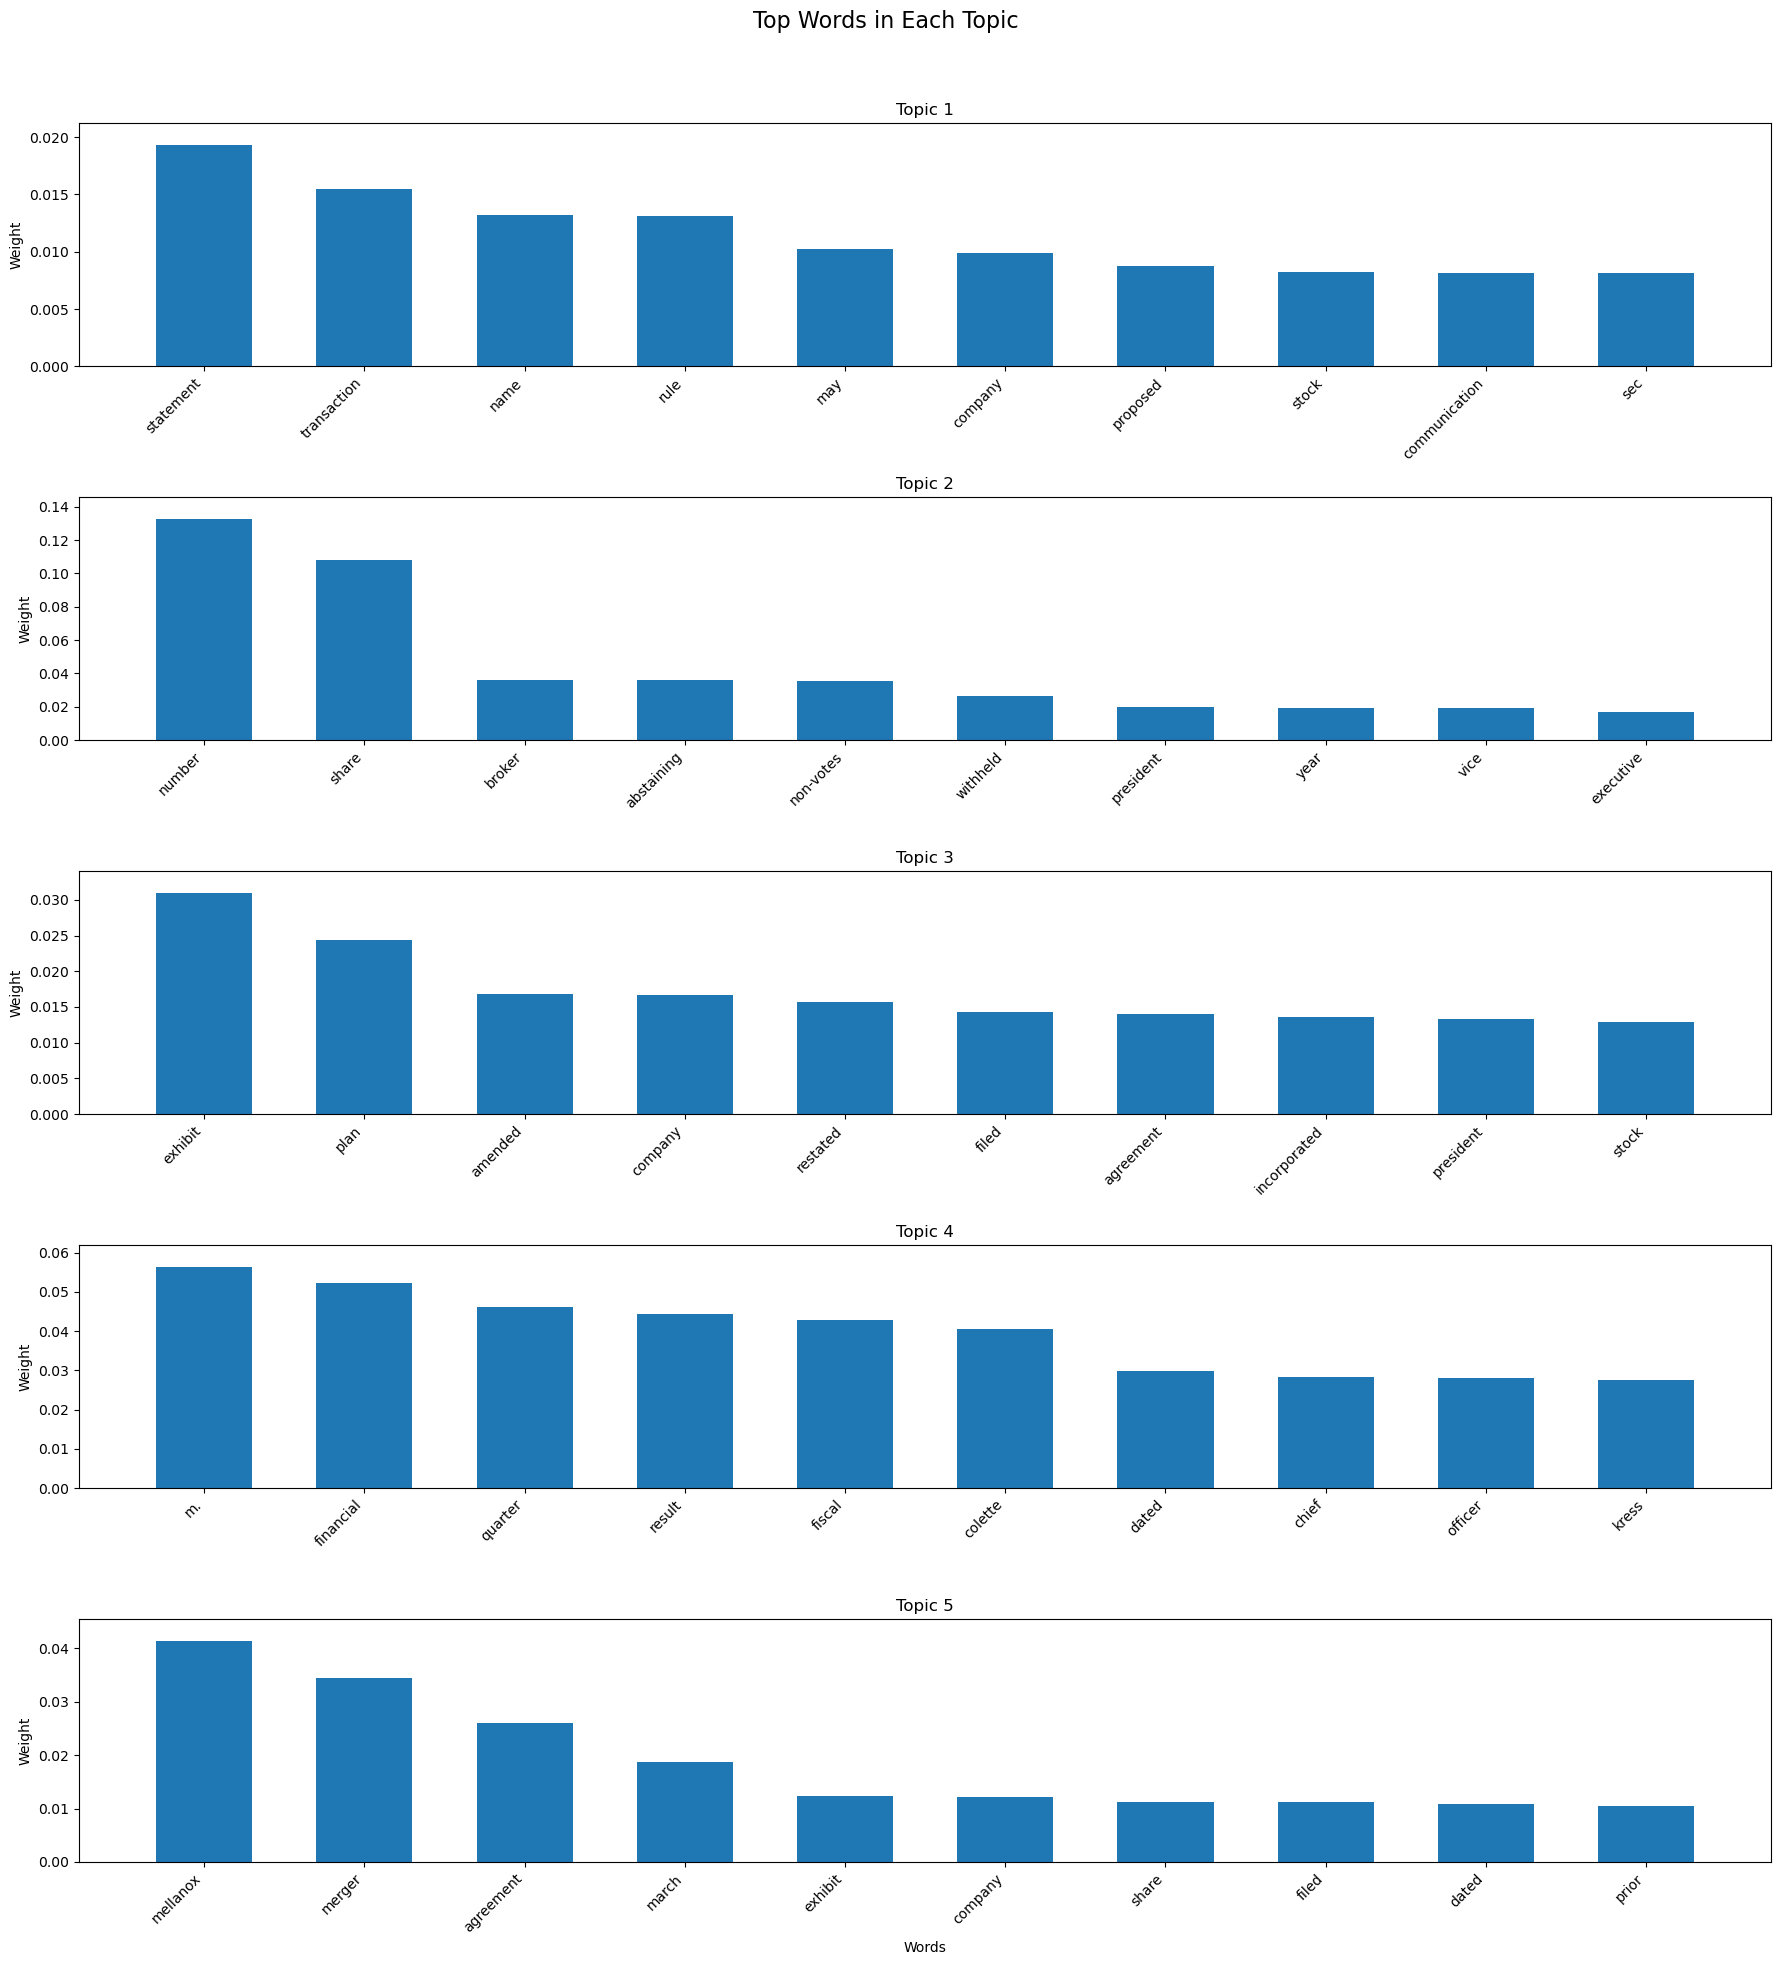

In [26]:
# Extract the topics from the LDA model
topics = lda_model.show_topics(num_topics=5, num_words=10, formatted=False)

# Increase figure width for better spacing of labels
fig, axes = plt.subplots(5, 1, figsize=(18, 20), sharex=False)  # Set sharex to False to handle each chart independently
fig.suptitle('Top Words in Each Topic', fontsize=16)

# Create a bar chart for each topic with explicit x-axis labels
for i, (topic_id, topic_words) in enumerate(topics):
    words, weights = zip(*topic_words)  # Extract words and their weights
    ax = axes[i]
    ax.bar(range(len(words)), weights, width=0.6, align='center')  # Use indices for bar positions
    ax.set_title(f'Topic {topic_id + 1}')
    ax.set_ylabel('Weight')
    ax.set_ylim(0, max(weights) * 1.1)
    ax.set_xticks(range(len(words)))  # Set the positions for the ticks
    ax.set_xticklabels(words, rotation=45, ha='right')  # Set words directly as labels on the x-axis

# Display the plot
plt.xlabel('Words')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [27]:
# Apply sentiment analysis
filing_df['Sentiment'] = filing_df['Processed Disclosure Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Display results
filing_sentiment = filing_df[['reportDate','CIK', 'Accession Number', 'Item', 'Sentiment']]
filing_sentiment.head()

,reportDate,CIK,Accession Number,Item,Sentiment
80,2024-07-02,0001045810,000104581016000292,Item 2.02 Results of Operations and Financial ...,-0.016667
81,2024-07-02,0001045810,000104581016000292,Item 9.01 Financial Statements and Exhibits.,0.000000
77,2024-07-05,0001045810,000104581016000356,Item 9.01. Financial Statements and Exhibits.,0.000000
76,2024-07-05,0001045810,000104581016000356,Item 5.03. Amendments to Articles of Incorpora...,0.081277
73,2024-07-09,0001045810,000104581016000358,Item 3.02. Unregistered Sales of Equity Securi...,0.000000


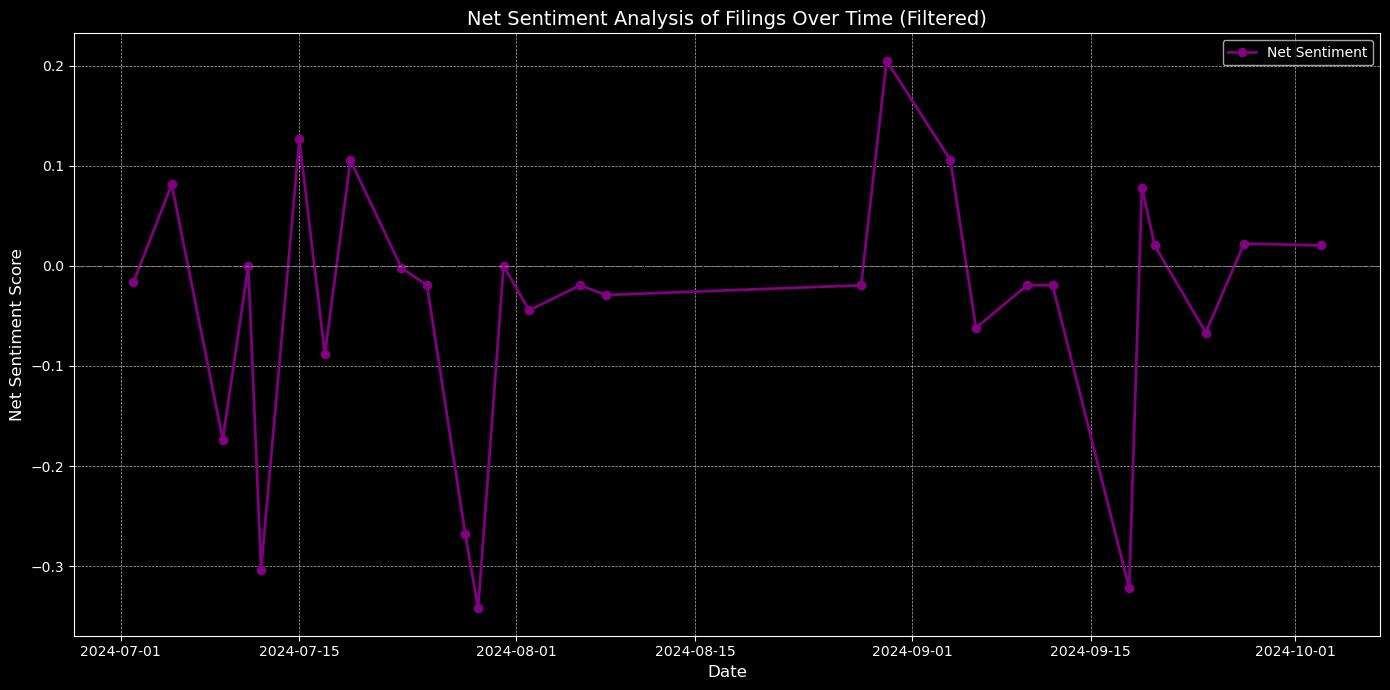

In [28]:
# Convert 'reportDate' to datetime format and sort by date
filing_sentiment.loc[:, 'reportDate'] = pd.to_datetime(filing_sentiment['reportDate'])

filing_sentiment = filing_sentiment.sort_values('reportDate')

# Compute net sentiment by summing daily sentiment values
daily_sentiment = filing_sentiment.groupby('reportDate')['Sentiment'].sum()

# Filter data to start from the first non-zero sentiment date
non_zero_sentiment = daily_sentiment[daily_sentiment != 0]
filtered_sentiment = daily_sentiment.loc[non_zero_sentiment.index[0]:]

# Set Style for Background
plt.style.use("dark_background")

# Plot net sentiment over time
plt.figure(figsize=(14, 7))
plt.plot(filtered_sentiment.index, filtered_sentiment, color='purple', marker='o', label='Net Sentiment', linewidth=2)

# Add horizontal line for neutral sentiment
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

# Customize plot labels, title, and legend
plt.title('Net Sentiment Analysis of Filings Over Time (Filtered)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net Sentiment Score', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


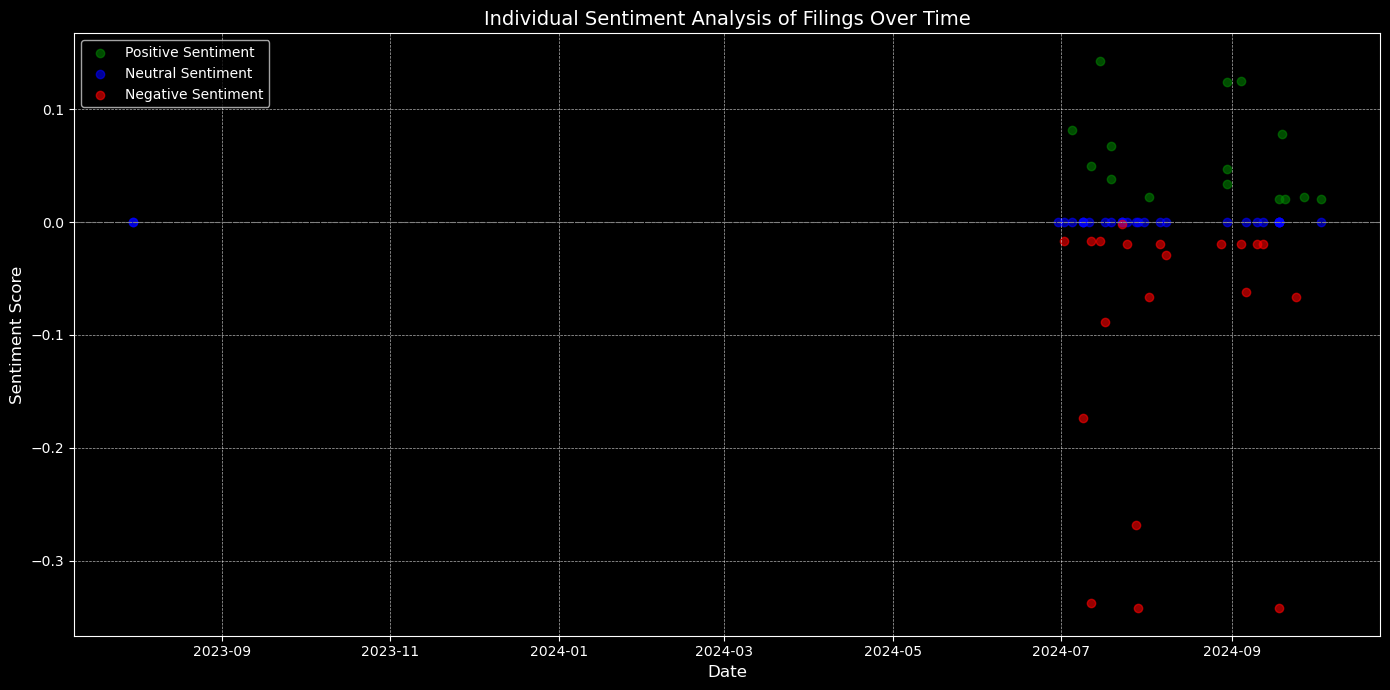

In [29]:
# Separate sentiment into positive, neutral, and negative categories
positive_sentiment = filing_sentiment[filing_sentiment['Sentiment'] > 0]
neutral_sentiment = filing_sentiment[filing_sentiment['Sentiment'] == 0]
negative_sentiment = filing_sentiment[filing_sentiment['Sentiment'] < 0]

# Set Style for Background
plt.style.use("dark_background")

# Plot individual sentiment scores
plt.figure(figsize=(14, 7))
plt.scatter(positive_sentiment['reportDate'], positive_sentiment['Sentiment'], color='green', label='Positive Sentiment', alpha=0.6)
plt.scatter(neutral_sentiment['reportDate'], neutral_sentiment['Sentiment'], color='blue', label='Neutral Sentiment', alpha=0.6)
plt.scatter(negative_sentiment['reportDate'], negative_sentiment['Sentiment'], color='red', label='Negative Sentiment', alpha=0.6)

# Add horizontal line for neutral sentiment
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

# Customize plot labels, title, and legend
plt.title('Individual Sentiment Analysis of Filings Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [30]:
# Load spaCy's English NER model
nlp = spacy.load('en_core_web_sm')

# Apply NER to the disclosure text
filing_df['Entities'] = filing_df['Processed Disclosure Text'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

# Display results
filing_df[['reportDate', 'CIK', 'Accession Number', 'Item', 'Entities']].head()


,reportDate,CIK,Accession Number,Item,Entities
80,2024-07-02,0001045810,000104581016000292,Item 2.02 Results of Operations and Financial ...,"[(august, DATE), (three six month ended july, ..."
81,2024-07-02,0001045810,000104581016000292,Item 9.01 Financial Statements and Exhibits.,"[(august, DATE), (second, ORDINAL), (august, D..."
77,2024-07-05,0001045810,000104581016000356,Item 9.01. Financial Statements and Exhibits.,"[(november, DATE), (november, DATE), (november..."
76,2024-07-05,0001045810,000104581016000356,Item 5.03. Amendments to Articles of Incorpora...,"[(november, DATE), (three year, DATE), (annual..."
73,2024-07-09,0001045810,000104581016000358,Item 3.02. Unregistered Sales of Equity Securi...,[]


In [31]:
# Flatten the list of entities and count the occurrences of each entity type
all_entities = [entity[1] for entities in filing_df['Entities'] for entity in entities]
entity_counts = Counter(all_entities)

# Display the most common entity types
entity_counts.most_common()

[('DATE', 371),
 ('PERSON', 145),
 ('ORG', 129),
 ('ORDINAL', 45),
 ('GPE', 30),
 ('CARDINAL', 13),
 ('TIME', 1),
 ('PRODUCT', 1),
 ('LAW', 1),
 ('NORP', 1)]

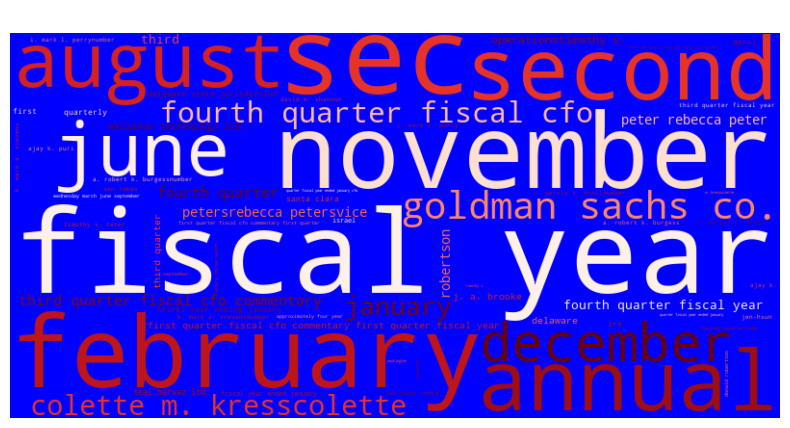

In [32]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400,
                   background_color="blue", colormap="Reds",
                   max_font_size=150, max_words=max_words)

    # Convert Series to frequency dictionary if needed
    if isinstance(word_freq, pd.Series):
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Remove stopwords from the frequency counter
    if stopwords is not None:
        counter = {token: freq for token, freq in counter.items() if token not in stopwords}

    wc.generate_from_frequencies(counter)

    # Set Style for Background
    plt.style.use("ggplot")

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Aggregate named entities into a list
entity_list = [entity[0] for entities in filing_df['Entities'] for entity in entities]

# Count the frequency of each entity
entity_word_freq = Counter(entity_list)

# Generate the word cloud for named entities
wordcloud(entity_word_freq, title="Named Entities Word Cloud")


In [33]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf.fit_transform(filing_df['Processed Disclosure Text'])

# Display top keywords
print(tfidf.get_feature_names_out())

['abstaining' 'agreement' 'amended' 'announces' 'base' 'broker' 'cfo'
 'chief' 'colette' 'commentary' 'company' 'compensation' 'corporationdate'
 'current' 'date' 'dated' 'description' 'duly' 'entitled' 'executive'
 'exhibit' 'filed' 'financial' 'fiscal' 'incorporated' 'kress'
 'kressexecutive' 'march' 'may' 'mellanox' 'merger' 'non' 'number'
 'officer' 'plan' 'president' 'press' 'quarter' 'reference' 'release'
 'report' 'restated' 'result' 'share' 'stock' 'subject' 'vice' 'votes'
 'withheld' 'year']


In [34]:
# Process stop words to match text splitting due to warning
processed_stopwords_TFIDF = list(TfidfVectorizer().build_tokenizer()(" ".join(stopwords_list)))

# Create the TF-IDF vectorizer with consistent stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=processed_stopwords_TFIDF, max_features=50)
tfidf_matrix = tfidf_vectorizer.fit_transform(filing_df['Processed Disclosure Text'])

# Display the shape of the TF-IDF matrix
print(tfidf_matrix.shape)

(65, 50)


In [35]:
# Convert to dense matrix
dense_matrix_TFIDF = tfidf_matrix.toarray()

# Get feature names from vectorizer
feature_names_TFIDF = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame with feature names as columns and document IDs as index
df_vectors_TFIDF = pd.DataFrame(dense_matrix_TFIDF, columns=feature_names_TFIDF, index=filing_df['Accession Number'])

# Display the DataFrame
df_vectors_TFIDF.head()

,abstaining,agreement,amended,announces,base,broker,cfo,chief,colette,commentary,...,restated,result,secretary,share,stock,subject,vice,votes,withheld,year
Accession Number,,,,,,,,,,,,,,,,,,,,,
000104581016000292,0.0,0.0,0.185851,0.000000,0.0,0.0,0.321953,0.081762,0.084706,0.429271,...,0.000000,0.201275,0.000000,0.0,0.000000,0.10499,0.075081,0.0,0.0,0.000000
000104581016000292,0.0,0.0,0.000000,0.281152,0.0,0.0,0.216032,0.082294,0.127885,0.216032,...,0.000000,0.405168,0.000000,0.0,0.000000,0.00000,0.075570,0.0,0.0,0.206870
000104581016000356,0.0,0.0,0.404156,0.000000,0.0,0.0,0.000000,0.177802,0.000000,0.000000,...,0.628188,0.000000,0.285550,0.0,0.000000,0.00000,0.163274,0.0,0.0,0.000000
000104581016000356,0.0,0.0,0.137823,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.856881,0.000000,0.194753,0.0,0.089673,0.00000,0.000000,0.0,0.0,0.381046
000104581016000358,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000


In [36]:
# Fit LDA model with 5 topics
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(tfidf_matrix)
H_lda_text_matrix = lda_text_model.components_

# Number of top words to display per topic
num_top_words = 10

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Loop through each topic and display the top words with weights rounded to 4 decimal places
for topic_idx, topic in enumerate(lda_text_model.components_):
    top_features = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    top_features_weights = [round(topic[i], 4) for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic #{topic_idx + 1}:")
    print("Words:", top_features)
    print("Weights:", top_features_weights)
    print("\n")

Topic #1:
Words: ['plan', 'restated', 'year', 'secretary', 'president', 'compensation', 'fiscal', 'amended', 'vice', 'exhibit']
Weights: [5.9844, 4.0409, 3.6492, 3.0915, 2.8317, 2.7022, 2.4553, 2.2888, 2.2865, 2.2789]


Topic #2:
Words: ['stock', 'number', 'company', 'report', 'date', 'current', 'executive', 'financial', 'base', 'amended']
Weights: [3.2206, 1.6965, 1.5152, 1.02, 0.7688, 0.6441, 0.5103, 0.5059, 0.2059, 0.2045]


Topic #3:
Words: ['agreement', 'share', 'mellanox', 'company', 'merger', 'filed', 'march', 'number', 'may', 'dated']
Weights: [3.9529, 2.915, 2.8123, 2.3452, 2.1835, 1.9811, 1.7232, 1.6348, 1.4994, 1.1687]


Topic #4:
Words: ['commentary', 'quarter', 'result', 'press', 'release', 'cfo', 'financial', 'fiscal', 'incorporated', 'reference']
Weights: [6.462, 6.2664, 5.9347, 5.7747, 5.7747, 5.3995, 4.6912, 4.6007, 3.4564, 3.3818]


Topic #5:
Words: ['financial', 'colette', 'kress', 'chief', 'dated', 'officer', 'vice', 'president', 'agreement', 'description']
Weights:

In [37]:
# Visualize LDA topics using pyLDAvis
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, tfidf_matrix, tfidf_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)